# Spark
## Logistic Regression
### Documentation example

In [1]:
import numpy as np
import pandas as pd

import findspark

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
random_seed = 1234

In [3]:
findspark.init()
findspark.find()

%matplotlib inline
sns.set_theme(style='darkgrid')
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

In [4]:
%%capture

spark = SparkSession.builder.appName('logReg_consulting_project').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/11/06 12:38:39 WARN Utils: Your hostname, Diego-desktop resolves to a loopback address: 127.0.1.1; using 172.27.76.109 instead (on interface eth0)
23/11/06 12:38:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/06 12:38:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.csv('../data/customer_churn.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [6]:
df.show(5)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|  Cynthia Norton|37.0|    

In [7]:
df.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn']

In [8]:
cols = [
    #'Names',
    'Age',
    'Total_Purchase',
    'Account_Manager',
    'Years',
    'Num_Sites',
    'Onboard_date',
    #'Location',
    #'Company',
    'Churn',
 ]

In [9]:
df = df.select(cols)
df.show(5)

+----+--------------+---------------+-----+---------+-------------------+-----+
| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|Churn|
+----+--------------+---------------+-----+---------+-------------------+-----+
|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|    1|
|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|    1|
|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|    1|
|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|    1|
|37.0|       9191.58|              0| 5.56|      9.0|2016-01-19 15:31:15|    1|
+----+--------------+---------------+-----+---------+-------------------+-----+
only showing top 5 rows



In [10]:
df.select(F.dayofweek(df['Onboard_date']).alias('dayOfWeek')).groupBy('dayOfWeek').count().orderBy('count').show()

+---------+-----+
|dayOfWeek|count|
+---------+-----+
|        1|  101|
|        6|  113|
|        7|  131|
|        2|  132|
|        3|  135|
|        4|  137|
|        5|  151|
+---------+-----+



In [11]:
df.select(F.month(df['Onboard_date']).alias('month')).groupBy('month').count().orderBy('count').show()

+-----+-----+
|month|count|
+-----+-----+
|   12|   67|
|    5|   67|
|    7|   68|
|   11|   69|
|    9|   70|
|   10|   70|
|    4|   71|
|    6|   72|
|    2|   74|
|    8|   76|
|    1|   90|
|    3|  106|
+-----+-----+



In [12]:
df = df.withColumn('Onboard_dayOfWeek', F.dayofweek(df['Onboard_date']))
df = df.withColumn('Onboard_month', F.month(df['Onboard_date']))

df.show(5)

+----+--------------+---------------+-----+---------+-------------------+-----+-----------------+-------------+
| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|Churn|Onboard_dayOfWeek|Onboard_month|
+----+--------------+---------------+-----+---------+-------------------+-----+-----------------+-------------+
|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|    1|                6|            8|
|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|    1|                3|            8|
|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|    1|                4|            6|
|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|    1|                3|            4|
|37.0|       9191.58|              0| 5.56|      9.0|2016-01-19 15:31:15|    1|                3|            1|
+----+--------------+---------------+-----+---------+-------------------+-----+-----------------+-------

In [13]:
df.columns

['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Churn',
 'Onboard_dayOfWeek',
 'Onboard_month']

In [14]:
features = [
    'Age',
    'Total_Purchase',
    'Account_Manager',
    'Years',
    'Num_Sites',
    #'Onboard_date',
    #'Company',
    #'Churn',
    'Onboard_dayOfWeek',
    'Onboard_month'
 ]

target = 'Churn'

In [15]:
print(f'Correlation with {target}')
for feature in features:
    corr_val = df.select(F.corr(target, feature)).collect()[0][0]
    print(f'\t{feature} : {corr_val}')

Correlation with Churn
	Age : 0.08592553706723392
	Total_Purchase : 0.02403089451822047
	Account_Manager : 0.07061077173214911
	Years : 0.2143285801724283
	Num_Sites : 0.5253980778988574
	Onboard_dayOfWeek : -0.0036063937243955946
	Onboard_month : 0.01908032165223663


In [16]:
dayOfWeek_encoder = OneHotEncoder(inputCol='Onboard_dayOfWeek', outputCol='dayOfWeek_Vec')
month_encoder = OneHotEncoder(inputCol='Onboard_month', outputCol='month_Vec')
manager_encoder = OneHotEncoder(inputCol='Account_Manager', outputCol='manager_Vec')

In [17]:
features = [
    'Age',
    'Total_Purchase',
    #'Account_Manager',
    'Years',
    'Num_Sites',
    #'Onboard_date',
    #'Company',
    #'Churn',
    #'Onboard_dayOfWeek',
    #'Onboard_month',
    #'dayOfWeek_Vec',
    #'month_Vec',
    'manager_Vec',
 ]

In [18]:
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features'
)

In [19]:
LogisticRegression?

Init signature:
LogisticRegression(
    *,
    featuresCol: str = 'features',
    labelCol: str = 'label',
    predictionCol: str = 'prediction',
    maxIter: int = 100,
    regParam: float = 0.0,
    elasticNetParam: float = 0.0,
    tol: float = 1e-06,
    fitIntercept: bool = True,
    threshold: float = 0.5,
    thresholds: Optional[List[float]] = None,
    probabilityCol: str = 'probability',
    rawPredictionCol: str = 'rawPrediction',
    standardization: bool = True,
    weightCol: Optional[str] = None,
    aggregationDepth: int = 2,
    family: str = 'auto',
    lowerBoundsOnCoefficients: Optional[pyspark.ml.linalg.Matrix] = None,
    upperBoundsOnCoefficients: Optional[pyspark.ml.linalg.Matrix] = None,
    lowerBoundsOnIntercepts: Optional[pyspark.ml.linalg.Vector] = None,
    upperBoundsOnIntercepts: Optional[pyspark.ml.linalg.Vector] = None,
    maxBlockSizeInMB: float = 0.0,
)
Docstring:     
Logistic regression.
This class supports multinomial logistic (softmax) and binom

In [20]:
model = LogisticRegression(
    featuresCol='features',
    labelCol=target
)

In [21]:
pipeline = Pipeline(
    stages=[
        #dayOfWeek_encoder,
        #month_encoder,
        manager_encoder,
        assembler,
        model
    ]
)

In [22]:
df_zeros = df.filter(df[target] == 0)
df_ones = df.filter(df[target] == 1)

train_zeros, test_zeros = df_zeros.randomSplit([0.7, 0.3], seed=random_seed)
train_ones, test_ones = df_ones.randomSplit([0.7, 0.3], seed=random_seed)

train = train_zeros.union(train_ones)
test = test_zeros.union(test_ones)

In [23]:
model_fit = pipeline.fit(train)

In [24]:
results = model_fit.transform(test)

In [25]:
model_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=target)

In [26]:
results.select(target, 'prediction').show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



In [27]:
results.groupBy(target).count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  222|
|    1|   51|
+-----+-----+



In [28]:
results.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  240|
|       1.0|   33|
+----------+-----+



In [29]:
AUC = model_eval.evaluate(results)
AUC

0.7511923688394276

___________

In [54]:
iters = 11
lambda_list = np.linspace(0, 1, iters)

model_list = []
AUC_list = []

for i, lamb in enumerate(lambda_list):
    
    model = LogisticRegression(
        featuresCol='features',
        labelCol=target,
        predictionCol='prediction',
        elasticNetParam=0,
        threshold=lamb,
    )
    
    pipeline = Pipeline(
        stages=[
            #dayOfWeek_encoder,
            #month_encoder,
            manager_encoder,
            assembler,
            model
        ]
    )
    
    model_fit = pipeline.fit(train)
    
    results = model_fit.transform(test)
    
    model_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=target)
    
    AUC = model_eval.evaluate(results)
    
    AUC_list.append(AUC)

In [55]:
from operator import itemgetter

AUX_max_index, AUX_max = max(enumerate(AUC_list), key=itemgetter(1))

best_lamb = lambda_list[AUX_max_index]

In [56]:
AUX_max_index

2

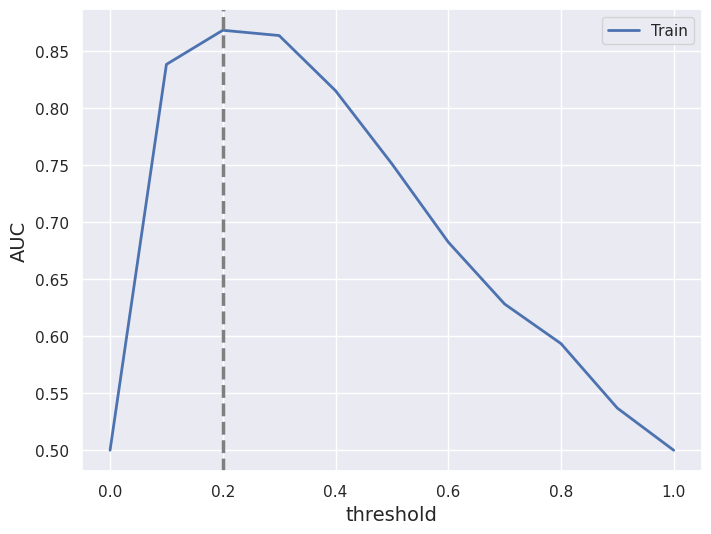

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lambda_list, AUC_list, linewidth=2, label='Train')

ax.axvline(x=best_lamb, color="tab:gray", linestyle="--")

#ax.set_xscale('log')
ax.set_ylabel('AUC', size=14)
ax.set_xlabel('threshold', size=14)

plt.legend()
plt.show()

In [58]:
train_all = train.union(test)

In [59]:
model = LogisticRegression(
    featuresCol='features',
    labelCol=target,
    predictionCol='prediction',
    elasticNetParam=0,
    threshold=best_lamb,
)

pipeline = Pipeline(
    stages=[
        #dayOfWeek_encoder,
        #month_encoder,
        manager_encoder,
        assembler,
        model
    ]
)

In [60]:
df_new = spark.read.csv('../data/new_customers.csv', header=True, inferSchema=True)
df_new.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)



In [61]:
model_fit = pipeline.fit(train_all)

results = model_fit.transform(df_new)

#model_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=target)

#AUC = model_eval.evaluate(results)

#AUC

In [62]:
results.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+-------------+--------------------+--------------------+--------------------+----------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|  manager_Vec|            features|       rawPrediction|         probability|prediction|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+-------------+--------------------+--------------------+--------------------+----------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|    (1,[],[])|[37.0,9935.53,7.7...|[2.22168680572549...|[0.90218015921765...|       0.0|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|21083 Nicole Junc...|   Cannon-Benson|    (1,[],[])|

In [63]:
results.select('Company', 'prediction').show()

+----------------+----------+
|         Company|prediction|
+----------------+----------+
|        King Ltd|       0.0|
|   Cannon-Benson|       1.0|
|Barron-Robertson|       1.0|
|   Sexton-Golden|       1.0|
|        Wood LLC|       1.0|
|   Parks-Robbins|       1.0|
+----------------+----------+



In [64]:
results.select('probability').collect()[0]

Row(probability=DenseVector([0.9022, 0.0978]))